In [1]:
import os
import tarfile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader

from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Download and Prepare the Dataset

In [2]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [3]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path="./data")

In [4]:
data_dir = "./data/cifar10"

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['deer', 'ship', 'dog', 'cat', 'airplane', 'automobile', 'frog', 'truck', 'horse', 'bird']


In [5]:
for dataset in os.listdir(data_dir):
  for class_name in classes:
    dataset_count = len(os.listdir(data_dir + "/{}/".format(dataset) + class_name))
    print("No. of {} examples for {}: {}".format(dataset, class_name, dataset_count))

No. of train examples for deer: 5000
No. of train examples for ship: 5000
No. of train examples for dog: 5000
No. of train examples for cat: 5000
No. of train examples for airplane: 5000
No. of train examples for automobile: 5000
No. of train examples for frog: 5000
No. of train examples for truck: 5000
No. of train examples for horse: 5000
No. of train examples for bird: 5000
No. of test examples for deer: 1000
No. of test examples for ship: 1000
No. of test examples for dog: 1000
No. of test examples for cat: 1000
No. of test examples for airplane: 1000
No. of test examples for automobile: 1000
No. of test examples for frog: 1000
No. of test examples for truck: 1000
No. of test examples for horse: 1000
No. of test examples for bird: 1000


## ImageFolder Dataset

In [6]:
dataset = ImageFolder(data_dir + "/train", transform=ToTensor())
len(dataset)

50000

In [7]:
image, label = dataset[0]
image.shape, label

(torch.Size([3, 32, 32]), 0)

In [8]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
RANDOM_SEED = 54
torch.manual_seed(RANDOM_SEED)

val_percent = 0.1
val_size = int(len(dataset) * val_percent)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [10]:
def show_example(image, label):
  print("Label: {} {}".format(dataset.classes[label], label))
  plt.imshow(image.permute(1, 2, 0))

Label: deer 4


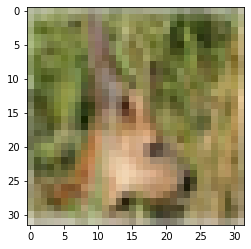

In [11]:
show_example(*train_ds[0])

Label: horse 7


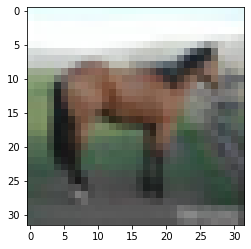

In [12]:
show_example(*train_ds[19])

Label: bird 2


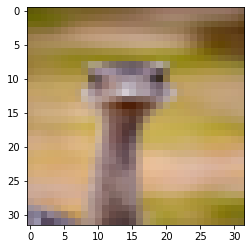

In [13]:
show_example(*train_ds[110])

## DataLoader

In [14]:
BATCH_SIZE = 128

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, BATCH_SIZE, num_workers=2, pin_memory=True)

In [24]:
# def show_batch(batch):
#   images, _ = batch
#   plt.figure(figsize=(16, 8))
#   plt.axis("off")
#   plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0))

def show_batch(dl):
  for images, _ in dl:
    fig, ax = plt.subplots(figsize= (16,8))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

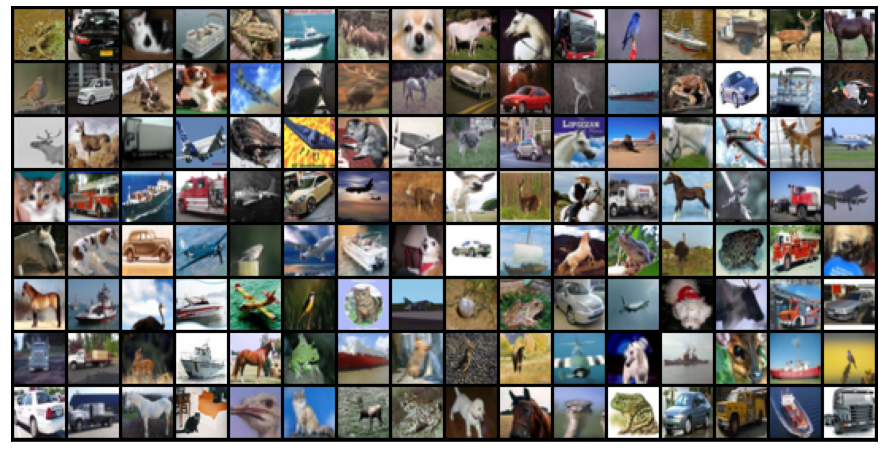

In [25]:
# show_batch(list(train_dl)[0])

show_batch(train_dl)

# GPU Device and DeviceDataLoader

In [17]:
def get_device():
  """Pick GPU if GPU is available, else pick CPU"""
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

In [18]:
device = get_device()
device

device(type='cuda')

In [19]:
def to_device(data, device):
  """Move Tensors to specified device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [20]:
class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for batch in self.dl:
      yield to_device(batch, self.device)

  def __len__(self):
    """Returns the number of batches in the dataloader"""
    return len(self.dl)

In [21]:
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)

# Model

In [26]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [52]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {"val_loss": loss, "val_acc": acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x["val_loss"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x["val_acc"] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], Train_Loss: {:.4f} Val_Loss: {:.4f}, Val_Acc: {:.4f}".format(epoch, result["train_loss"], result["val_acc"]))

In [30]:
from torch.nn.modules.pooling import MaxPool2d
class CIFAR10Model(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        # input size 3 x 32 x 32
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),   # output size 64 x 16 x 16

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),   # output size 128 x 8 x 8

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),   # output size 256 x 4 x 4

        nn.Flatten(),
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10))    # output size 10

  def forward(self, xb):
    return self.network(xb)

In [31]:
model = CIFAR10Model()
model = to_device(model, device)
model

CIFAR10Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feature

# Training the Model

In [46]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [47]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  optimizer = opt_func(model.parameters(), lr)
  history = []

  for epoch in range(epochs):
    # Training Step
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation Step
    result = evaluate(model, val_loader)
    result["train_loss"] = torch.stack(train_losses).mean().item()
    history.append(result)
    model.epoch_end(epoch, result)

  return history

In [49]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.10488281399011612, 'val_loss': 2.3021304607391357}]

In [50]:
num_epochs = 10
opt_func = torch.optim.Adam # read up
lr = 0.001

# Log Hyperparameters
opt_func.__name__

In [51]:
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], Val_Loss: 1.4029, Val_Acc: 0.4881
Epoch [1], Val_Loss: 1.0956, Val_Acc: 0.6070
Epoch [2], Val_Loss: 0.9407, Val_Acc: 0.6635
Epoch [3], Val_Loss: 0.8328, Val_Acc: 0.7111
Epoch [4], Val_Loss: 0.7449, Val_Acc: 0.7486
Epoch [5], Val_Loss: 0.7225, Val_Acc: 0.7723
Epoch [6], Val_Loss: 0.7134, Val_Acc: 0.7717
Epoch [7], Val_Loss: 0.7829, Val_Acc: 0.7746
Epoch [8], Val_Loss: 0.8784, Val_Acc: 0.7664
Epoch [9], Val_Loss: 0.9790, Val_Acc: 0.7563


In [ ]:
# Log Metrics

# Model Analysis

In [60]:
def plot_accuracies(history):
  accuracies = [x["val_acc"] for x in history]
  plt.figure(figsize=(8,8))
  plt.plot(accuracies, '-x')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs. No. Epochs")

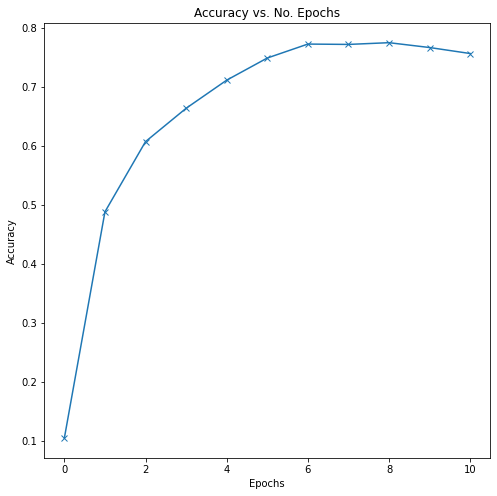

In [62]:
plot_accuracies(history)

In [69]:
def plot_losses(history):
  train_loss = [x["train_loss"] for x in history[1:-1]]
  val_loss = [x["val_loss"] for x in history]
  plt.figure(figsize=(8,8))
  plt.plot(train_loss, '-rx')
  plt.plot(val_loss, '-bx')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["Training", "Validation"])
  plt.title("Loss vs. No. Epochs")

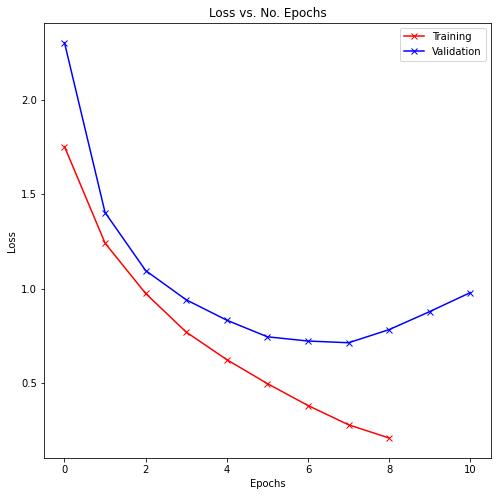

In [70]:
plot_losses(history)

# Testing

## Test on Individual Images

In [81]:
test_dataset = ImageFolder(data_dir+"/test", transform=ToTensor())

In [82]:
def predict_image(image, model):
  image = to_device(image.unsqueeze(0), device)
  out = model(image)
  _, preds = torch.max(out, dim=1)
  return preds[0].item()

Label: automobile Predicted: automobile


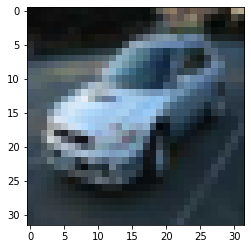

In [84]:
image, label = test_dataset[1017]
plt.imshow(image.permute(1, 2, 0))
print("Label: {} Predicted: {}".format(dataset.classes[label], dataset.classes[predict_image(image, model)]))

Label: horse Predicted: horse


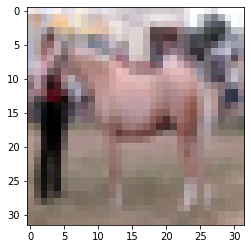

In [85]:
image, label = test_dataset[7025]
plt.imshow(image.permute(1, 2, 0))
print("Label: {} Predicted: {}".format(dataset.classes[label], dataset.classes[predict_image(image, model)]))

Label: bird Predicted: bird


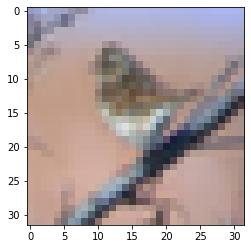

In [86]:
image, label = test_dataset[2011]
plt.imshow(image.permute(1, 2, 0))
print("Label: {} Predicted: {}".format(dataset.classes[label], dataset.classes[predict_image(image, model)]))

## Evaluate on the Test Set

In [87]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, BATCH_SIZE*2), device)
test_result = evaluate(model, test_loader)
test_result

{'val_acc': 0.7523437738418579, 'val_loss': 0.9764701724052429}

Performance is comparable to that on the validation set. We have a good distribution in the validation set!

In [88]:
# Log Metrics

# Save the Model

In [89]:
torch.save(model.state_dict(), "cifar10_cnn.pth")

In [91]:
model2 = to_device(CIFAR10Model(), device)
model2.load_state_dict(torch.load("cifar10_cnn.pth"))

<All keys matched successfully>

In [92]:
evaluate(model2, test_loader)

{'val_acc': 0.7523437738418579, 'val_loss': 0.9764701724052429}

In [ ]:
# Save the experiment